### **Prepare necessary packages**

In [1]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 2.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 62.6 MB/s eta 0:00

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from transformers import BertTokenizer
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import re
import datasets
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

### **Preprocess the dataset, generate inputs.**

In [3]:
dataset = load_dataset("humicroedit", "subtask-1")
train_set = dataset['train']

Generating train split:   0%|          | 0/9652 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3024 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2419 [00:00<?, ? examples/s]

Generating funlines split:   0%|          | 0/8248 [00:00<?, ? examples/s]

Dataset humicroedit downloaded and prepared to /root/.cache/huggingface/datasets/humicroedit/subtask-1/0.0.0/209c209bc70671d8d939aefd82e51f8ff294e47504ec64ef653a93a1f13e9ed3. Subsequent calls will reuse this data.


  0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
# Preprocess the dataset
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess(example):
    original_text = example['original']
    edited_text = example['edit']
    label = example['meanGrade']
    
    # Find the target word in the original text
    target_word_match = re.search(r'<(.+?)/>', original_text)
    target_word = target_word_match.group(0)
    
    # Replace target word with edited word in original sentence
    input_text = original_text.replace(target_word, edited_text, 1)
    
    edits = tokenizer(input_text, return_tensors='pt')
    originals = tokenizer(original_text, return_tensors='pt')
    label = torch.tensor(label, dtype=torch.float32)
    

    return {'edited': edits['input_ids'][0], 'label': label}

preprocessed_dataset = dataset.map(preprocess)

# Split the dataset
train_dataset, val_dataset = preprocessed_dataset['train'], preprocessed_dataset['validation']
test_dataset = preprocessed_dataset['test']

new_train_dataset = []
new_val_dataset = []
new_test_dataset = []
originalhumor = []

for example in train_dataset:
    new_example = []
    new_example.append(torch.tensor(example['edited']))
    new_example.append(torch.tensor(example['label']))
    new_train_dataset.append(new_example)

for example in val_dataset:
    new_example1 = []
    new_example1.append(torch.tensor(example['edited']))
    new_example1.append(torch.tensor(example['label']))
    new_val_dataset.append(new_example1)

for example in test_dataset:
    new_example2 = []
    new_example2.append(torch.tensor(example['edited']))
    new_example2.append(torch.tensor(example['label']))
    new_test_dataset.append(new_example2)
    originalhumor.append(example['label'])

print(new_train_dataset[0])
print(new_val_dataset[0])
print(new_test_dataset[0])

Map:   0%|          | 0/9652 [00:00<?, ? examples/s]

Map:   0%|          | 0/3024 [00:00<?, ? examples/s]

Map:   0%|          | 0/2419 [00:00<?, ? examples/s]

Map:   0%|          | 0/8248 [00:00<?, ? examples/s]

[tensor([ 101, 2605, 2003, 1520, 5933, 2091, 2049, 4480, 2040, 2587, 8178, 1521,
        2302, 3979, 1999, 5712,  102]), tensor(0.2000)]
[tensor([  101,  5190,  1997,  5637,  1998, 22437, 26699,  7979,  1997,  2146,
         1011,  8961,  4424, 18421,  2024, 12770, 14933,  2098,   102]), tensor(1.)]
[tensor([  101,  1996,  6745,  1024,  2602, 19552,  3065,  3765,  3810,  2157,
          102]), tensor(1.2000)]


### **Prepare the Dataloader**

In [5]:
# Do pad sequence to make sure inputs share same length
def collate_fn(batch):
    edit, labels = zip(*batch)
    padded_edit = torch.nn.utils.rnn.pad_sequence(edit, batch_first=True,padding_value=0)
    new_labels = torch.Tensor(labels)
    return (padded_edit, new_labels)

# Create dataloader
batch_size = 32
trainloader = torch.utils.data.DataLoader(
    new_train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)

valloader = torch.utils.data.DataLoader(
    new_val_dataset, batch_size=batch_size, shuffle=False,collate_fn=collate_fn)

testloader = torch.utils.data.DataLoader(
    new_test_dataset, batch_size=batch_size, shuffle=False,collate_fn=collate_fn)



In [6]:
# Use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### **Create a simple LSTM model and training**

In [7]:
class SimpleLSTM(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim):
        super(SimpleLSTM, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, inputs):
        x = self.embeddings(inputs)
        x, h = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x


In [8]:

# Initialize the model and optimizer
# Define the loss function

print(tokenizer.vocab_size)
model = SimpleLSTM(num_embeddings = tokenizer.vocab_size, embedding_dim=100, hidden_dim=128).to(device)
criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = transformers.AdamW(model.parameters(), lr=0.001)
HUMOR_THRESHOLD = 0.94
num_epochs = 20
best_val_loss = float('inf')
predicted_scores = []
train_loss = 0
val_loss = 0

train_loss_dataset = []
val_loss_dataset = []
train_acc_dataset = []
val_acc_dataset = []

for epoch in range(num_epochs):

    train_true = []
    train_pred = []
    val_true = []
    val_pred = []


    model.train()
    # train_losses_epoch = []
    print(f"Training epoch {epoch+1}...")
    for i, batch in enumerate(trainloader):
        edited, label = batch
        label = label.to(device)
        edited = edited.to(device)
        outputs = model(edited).squeeze()
        loss = criterion(outputs, label)
        # train_losses_epoch.append(loss.item())

        train_true += label.tolist()
        train_pred += outputs.tolist()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # train_rmse_loss = torch.sqrt(torch.mean(torch.Tensor(train_losses_epoch)))
    train_loss /= len(new_train_dataset)
    train_loss_dataset.append(train_loss)
    print(f"Training Loss: {train_loss:.5f}")
    # print(f"RMSE Training Loss: {train_rmse_loss:.5f}")

    # Validation
    model.eval()
    val_losses_epoch = []
    
    with torch.no_grad():
        for i, batch in enumerate(valloader):
            edited, label = batch
            label = label.to(device)
            edited = edited.to(device)

            val_true += label.tolist()

            outputs = model(edited).squeeze()

            loss = criterion(outputs, label)

            val_pred += outputs.tolist()

            val_losses_epoch.append(loss.item())
            val_loss += loss.item()

    val_rmse_loss = torch.sqrt(torch.mean(torch.Tensor(val_losses_epoch)))
    val_loss /= len(new_val_dataset)
    val_loss_dataset.append(val_loss)
    print(f"Validation Loss: {val_loss:.5f}")
    # print(f"RMSE Validation Loss: {val_rmse_loss:.5f}")

    train_humor_true = [1 if float(i) > HUMOR_THRESHOLD else 0 for i in train_true]
    train_humor_pred = [1 if float(i) > HUMOR_THRESHOLD else 0 for i in train_pred]
    val_humor_true = [1 if float(i) > HUMOR_THRESHOLD else 0 for i in val_true]
    val_humor_pred = [1 if float(i) > HUMOR_THRESHOLD else 0 for i in val_pred]
    curr_train_acc = accuracy_score(train_humor_true, train_humor_pred)
    curr_val_acc = accuracy_score(val_humor_true, val_humor_pred)
    train_acc_dataset.append(curr_train_acc)
    val_acc_dataset.append(curr_val_acc)

    print(f"Validation Acc: {curr_val_acc:.5f}")
    print(f"Training Acc: {curr_train_acc:.5f}")
    
    # Save model
    if val_rmse_loss < best_val_loss:
        best_val_loss = val_rmse_loss
        best_model_params = model.state_dict()
        torch.save(model.state_dict(), "best_model.pt")

    

print("Training complete.")


30522


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training epoch 1...
Training Loss: 0.01099
Validation Loss: 0.01059
Validation Acc: 0.48326
Training Acc: 0.50073
Training epoch 2...
Training Loss: 0.01076
Validation Loss: 0.01056
Validation Acc: 0.51840
Training Acc: 0.50508
Training epoch 3...
Training Loss: 0.01071
Validation Loss: 0.01055
Validation Acc: 0.51716
Training Acc: 0.50591
Training epoch 4...
Training Loss: 0.01063
Validation Loss: 0.01052
Validation Acc: 0.51426
Training Acc: 0.51554
Training epoch 5...
Training Loss: 0.01016
Validation Loss: 0.01048
Validation Acc: 0.53121
Training Acc: 0.57273
Training epoch 6...
Training Loss: 0.00888
Validation Loss: 0.01090
Validation Acc: 0.52790
Training Acc: 0.64826
Training epoch 7...
Training Loss: 0.00740
Validation Loss: 0.01188
Validation Acc: 0.53783
Training Acc: 0.71115
Training epoch 8...
Training Loss: 0.00615
Validation Loss: 0.01230
Validation Acc: 0.54527
Training Acc: 0.74927
Training epoch 9...
Training Loss: 0.00512
Validation Loss: 0.01268
Validation Acc: 0.54

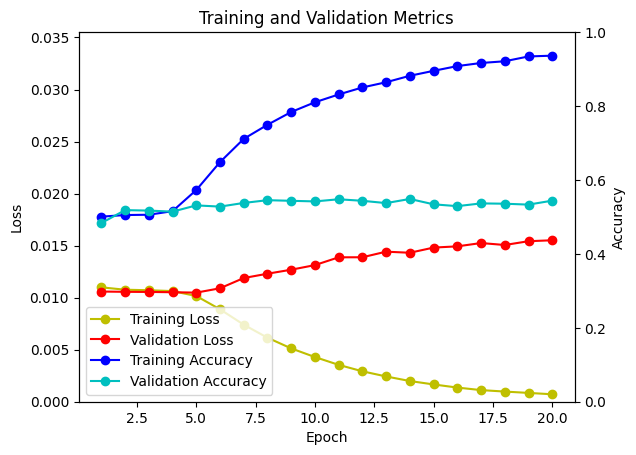

In [12]:
# plot graph
epochs = range(1, num_epochs+1, 1)
max_loss = max(max(train_loss_dataset), max(val_loss_dataset))

# plot loss
fig, ax1 = plt.subplots()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_ylim([0, max_loss+0.02])
plt1 = ax1.plot(epochs, train_loss_dataset, 'yo-', label='Training Loss')
plt2 = ax1.plot(epochs, val_loss_dataset, 'ro-', label='Validation Loss')

# plot accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy")
ax2.set_ylim([0,1])
plt3 = ax2.plot(epochs, train_acc_dataset, 'bo-', label='Training Accuracy')
plt4 = ax2.plot(epochs, val_acc_dataset, 'co-', label='Validation Accuracy')

plts = plt1 + plt2 + plt3 + plt4
labs = [p.get_label() for p in plts]
ax2.legend(plts, labs, loc=0)
# fig.tight_layout()
fig_name = "Training and Validation Metrics"
plt.title(fig_name)
plt.savefig('/content/lstm.png')
plt.show()

In [10]:
test_loss = 0.0
total = 0
mse = 0.0
res = []

#load the best model and predict
model.load_state_dict(best_model_params)
model.eval()
with torch.no_grad():
    for batch in testloader:
        x_edited, y = batch
        y = y.to(device)
        x_edited = x_edited.to(device)
        y_hat = model(x_edited).squeeze()
        loss = criterion(y_hat, y)
        test_loss += loss.item()
        total += y.size(0)
        res.extend(y_hat.tolist())
        mse += torch.mean((y_hat - y)**2) * y.size(0)

test_loss /= len(new_test_dataset)
rmse = torch.sqrt(mse / total)

print(f"Test loss: {test_loss:.4f}, RMSE: {rmse:.4f}")


Test loss: 0.0146, RMSE: 0.6834


In [11]:
# Create our own way to do precision_recall_fscore_support
for i in range(len(originalhumor)):
    if originalhumor[i] > 0.94:
        originalhumor[i] = 1
    else:
        originalhumor[i] = 0

print(originalhumor)

for i in range(len(res)):
    if res[i] > 0.94:
        res[i] = 1
    else:
        res[i] = 0

print(res)

precision, recall, f1, support = precision_recall_fscore_support(
    originalhumor, res, average='binary')

print(f"Test Results:")
print(f"RMSE Loss: {rmse:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-measure: {f1:.5f}")

[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 